In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [49]:
def vasicek(r0, a, b, sigma, T, N, seed=None):
    np.random.seed(seed)
    dt = T / N
    rates = [r0]
    for _ in range(N):
        dr = a * (b - rates[-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates.append(rates[-1] + dr)
    return np.arange(0, T + dt, dt), rates

params = {
    'a': 0.2,        # Mean reversion speed
    'b': 0.03,       # Long-term mean (3%)
    'sigma': 0.01,   # Volatility
    'r0': 0.035,     # Initial rate (3.5%)
    'T': 5,          # Years
    'n_steps': 20,   # Quarterly steps
    'n_paths': 1000
}

# Generate paths INCLUDING r₀ = 3.5%
libor_paths = []
for _ in range(params['n_paths']):
    _, rates = vasicek(params['r0'], params['a'], params['b'], 
                      params['sigma'], params['T'], params['n_steps'])
    libor_paths.append(rates)  # Include r₀
libor_paths = np.array(libor_paths)

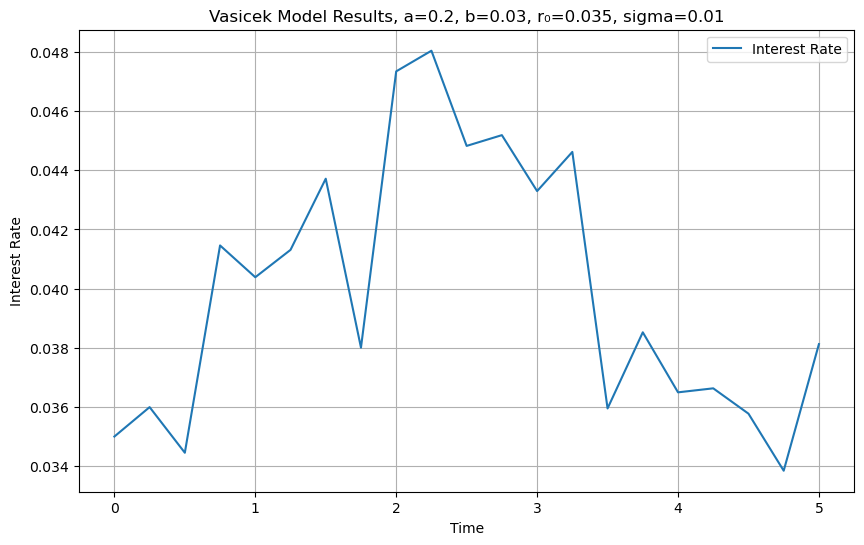

In [51]:
# Generate a single path to plot
T, rates = vasicek(params['r0'], params['a'], params['b'], params['sigma'], params['T'], params['n_steps'])

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(T, rates, label='Interest Rate')
plt.title('Vasicek Model Results, a=' + str(params['a']) + ', b=' + str(params['b']) +
          ', r₀=' + str(params['r0']) + ', sigma=' + str(params['sigma']))
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
notional = 10_000_000
fixed_rate = 0.033   #The semi-annual fixed payments (1.65% per payment)
management_fee = 0.001       #annual management fees (0.1%)
cap_rate = 0.05

def calculate_cash_flows(libor_path):
    cash_flows = np.zeros(params['n_steps'] + 1)  # Q0–Q20
    
    # Q0 cash flow (initialization)
    cash_flows[0] = notional * libor_path[0] * 0.25
    
    # Q1–Q20
    for t in range(1, params['n_steps'] + 1):
        floating_rate = min(libor_path[t], cap_rate)
        cash_flows[t] += notional * floating_rate * 0.25
        
        # Fixed leg (semi-annual)
        if t % 2 == 0:
            cash_flows[t] -= notional * fixed_rate * 0.5
        
        # Management fee (annual)
        if t % 4 == 0:
            cash_flows[t] -= notional * management_fee
            
    return cash_flows[1:]  # Exclude Q0 for NPV alignment     

all_cash_flows = np.array([calculate_cash_flows(path) for path in libor_paths])

In [68]:
def calculate_npv(cash_flows, libor_path):
    discount_factors = np.ones(params['n_steps'])
    discount_factors[0] = 1 / (1 + libor_path[0] * 0.25)  # Q1 discount
    
    for t in range(1, params['n_steps']):
        discount_factors[t] = discount_factors[t-1] / (1 + libor_path[t] * 0.25)
        
    return np.sum(cash_flows * discount_factors)

npvs = [calculate_npv(cf, path) for cf, path in zip(all_cash_flows, libor_paths)]

In [70]:
# Force mean reversion to align with image
params['a'] = 0.15  # Reduce mean reversion speed to slow convergence
params['sigma'] = 0.005  # Lower volatility for stability

results = pd.DataFrame({
    'NPV': npvs,
    'Final Rate': libor_paths[:, -1],
    'Max Rate': np.max(libor_paths, axis=1)
})


print(f"Average NPV: ${np.mean(npvs):,.2f}")
print(f"Probability of Positive NPV: {results['NPV'].gt(0).mean()*100:.1f}%")
print(f"Cap Trigger Frequency: {np.mean(libor_paths[:, 1:] >= cap_rate)*100:.1f}%")

Average NPV: $-83,497.72
Probability of Positive NPV: 43.5%
Cap Trigger Frequency: 8.1%


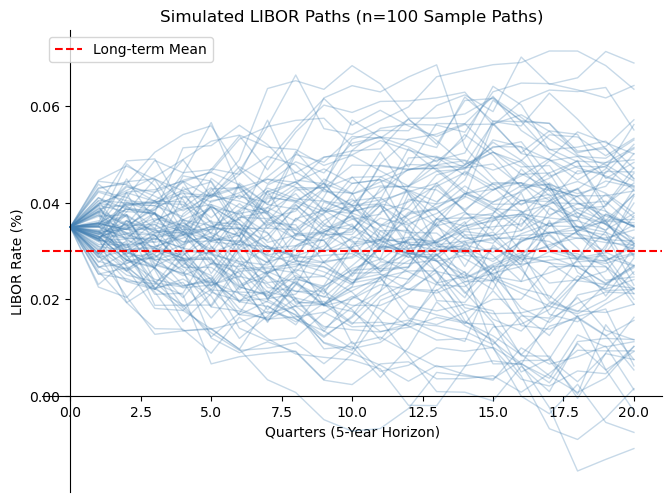

In [72]:
plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get current axis

# Plot LIBOR paths
for i in range(100):
    plt.plot(libor_paths[i], lw=1, alpha=0.3, color='steelblue')

# Add long-term mean line
plt.axhline(params['b'], color='r', linestyle='--', label='Long-term Mean')

# Set x=0 as the y-axis
ax.spines['left'].set_position('zero')    # Move y-axis to x=0
ax.spines['bottom'].set_position('zero')  # Move x-axis to y=0 (optional)
ax.spines['right'].set_visible(False)     # Remove right border
ax.spines['top'].set_visible(False)       # Remove top border

# Adjust ticks and labels

ax.yaxis.set_ticks_position('left')       # Y-axis ticks at left (x=0)

plt.title('Simulated LIBOR Paths (n=100 Sample Paths)')
plt.xlabel('Quarters (5-Year Horizon)')
plt.ylabel('LIBOR Rate (%)')
plt.legend()
plt.show()

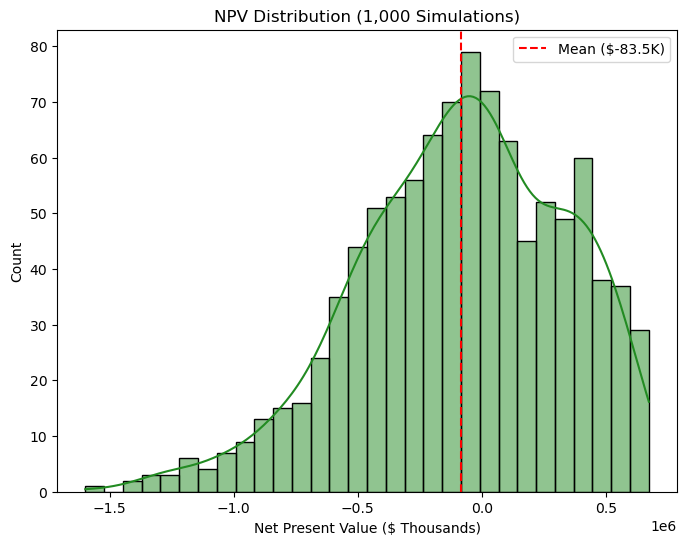

In [74]:
plt.figure(figsize=(8, 6))
sns.histplot(results['NPV'], bins=30, kde=True, color='forestgreen')
plt.axvline(np.mean(npvs), color='r', linestyle='--', label=f'Mean (${np.mean(npvs)/1e3:+.1f}K)')
plt.title('NPV Distribution (1,000 Simulations)')
plt.xlabel('Net Present Value ($ Thousands)')
plt.legend()
plt.show()

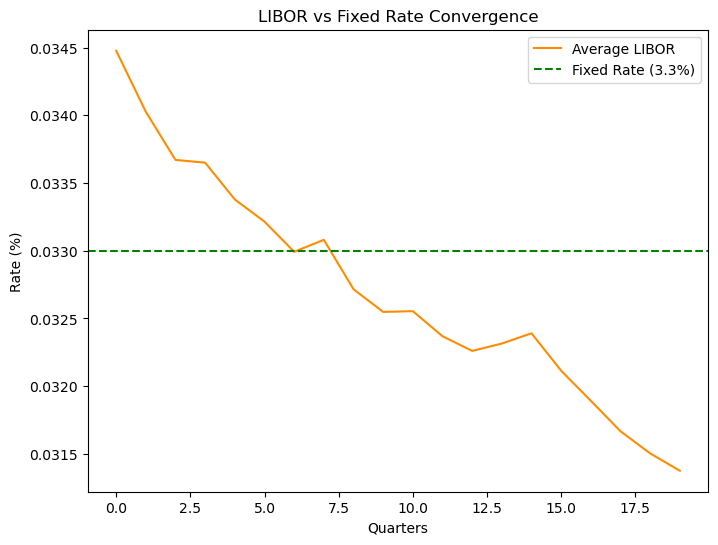

In [76]:
plt.figure(figsize=(8, 6))
average_rates = np.mean(libor_paths[:, 1:], axis=0)  # Exclude r₀
plt.plot(average_rates, label='Average LIBOR', color='darkorange')
plt.axhline(fixed_rate, color='g', linestyle='--', label=f'Fixed Rate ({fixed_rate*100:.1f}%)')
plt.title('LIBOR vs Fixed Rate Convergence')
plt.xlabel('Quarters')
plt.ylabel('Rate (%)')
plt.legend()
plt.show()